In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/narou/sample_submission.csv
/kaggle/input/narou/train.csv
/kaggle/input/narou/test.csv


In [2]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=2620f00ed6c3b8ebb3609641ee13a62618a05eabf1b08e503545ae05407426ca
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [3]:
import japanize_matplotlib

In [4]:
train = pd.read_csv("/kaggle/input/narou/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75544 entries, 0 to 75543
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   novel_id                   75544 non-null  int64  
 1   title                      75544 non-null  object 
 2   writer                     75542 non-null  object 
 3   biggenre                   75544 non-null  object 
 4   genre                      75544 non-null  object 
 5   keyword                    74800 non-null  object 
 6   isr15                      75544 non-null  object 
 7   isbl                       75544 non-null  object 
 8   isgl                       75544 non-null  object 
 9   iszankoku                  75544 non-null  object 
 10  istensei                   75544 non-null  object 
 11  istenni                    75544 non-null  object 
 12  kaiwaritu                  75544 non-null  float64
 13  length_per_story           75544 non-null  flo

# Data pre-processing

In [5]:
train.isna().sum()

novel_id                       0
title                          0
writer                         2
biggenre                       0
genre                          0
keyword                      744
isr15                          0
isbl                           0
isgl                           0
iszankoku                      0
istensei                       0
istenni                        0
kaiwaritu                      0
length_per_story               0
sasie_cnt_per_story            0
time_per_story_submission      0
global_point                   0
fav_novel_cnt                  0
all_point                      0
dtype: int64

## Finding all unique genres

In [6]:
genre_collection = train["genre"].unique().tolist()
genre_dict = dict()
for i, el in enumerate(genre_collection):
    genre_dict[el] = i
print(genre_dict)

{'VRゲーム〔SF〕': 0, '異世界〔恋愛〕': 1, '現実世界〔恋愛〕': 2, 'ローファンタジー〔ファンタジー〕': 3, 'コメディー〔文芸〕': 4, 'ハイファンタジー〔ファンタジー〕': 5, '歴史〔文芸〕': 6, 'エッセイ〔その他〕': 7, 'パニック〔SF〕': 8, 'ヒューマンドラマ〔文芸〕': 9, 'ホラー〔文芸〕': 10, '推理〔文芸〕': 11, 'ノンジャンル〔ノンジャンル〕': 12, '純文学〔文芸〕': 13, '詩〔その他〕': 14, 'リプレイ〔その他〕': 15, '宇宙〔SF〕': 16, 'アクション〔文芸〕': 17, '空想科学〔SF〕': 18, 'その他〔その他〕': 19, '童話〔その他〕': 20}


## Tagging novels that don't have tags (keywords)

In [7]:
train.fillna({"keyword":"UNTAGGED_NOVEL"}, inplace=True)
train.isna().sum()

novel_id                     0
title                        0
writer                       2
biggenre                     0
genre                        0
keyword                      0
isr15                        0
isbl                         0
isgl                         0
iszankoku                    0
istensei                     0
istenni                      0
kaiwaritu                    0
length_per_story             0
sasie_cnt_per_story          0
time_per_story_submission    0
global_point                 0
fav_novel_cnt                0
all_point                    0
dtype: int64

## One-hot encoding most popular keywords

In [8]:
def str_tags_to_set(tags):
    return set(tags.split(" "))

train["keywords_set"] = train["keyword"].apply(lambda x: str_tags_to_set(x))
keywords_set_list = train["keywords_set"].tolist()
keywords_collection = set()


for i in keywords_set_list:
    keywords_collection.update(i)
keywords_dict = dict()
for i, el in enumerate(keywords_collection):
    keywords_dict[el] = i

In [9]:
len(keywords_dict)

81075

Too many unique keywords to do naive one-hot encoding (considering every possible keyword)

In [10]:
print(list(keywords_dict.keys())[:50])

['', '龍×人間', '家出少年', 'CERO\u3000B', '結婚観', '変わった日常', '幼馴染まない', '与力見習い', 'メディアワークス文庫', '別世界交流', '恋愛要素は…？', 'ムキムキ神殿長', '精神的恐怖', '児童', '後方彼氏面系令嬢', 'ヒロインは実力者', '恋華', '普通受け', '押し付けられた婚約者', 'ロボっ子', '仄暗いお話', 'チートは主人公以外', '「春・花小説」', '伊野澄市', 'オレンジの屋根', 'ほいのほいのほい', '特撮女形', '箱庭療法', 'パン職人', 'ランクS', '恋愛を全力で応援し隊', 'あたしの人生について', '橫浜の銅御殿', '作者は文才欲しい', '戦いなし', '少しシリアス展開あり', 'タヒチ', '全ステータス0', '中華風／中華', 'こっそり異世界転生', 'サブヒロインが最強', 'プチざまぁ', 'オリジナル戦記？', 'ネタバレ注意！', '空想怪談', 'そもそも登場しない', 'ランキング攻略', '婚活？', 'デマ', '身長差コンビ']


In [11]:
from collections import Counter

KEYWORDS_DICT_SIZE = 250

keywords_array = train['keyword'].str.split()
keywords_array_flattened = [keyword for individual_list in keywords_array for keyword in individual_list]
keywords_counter = Counter(keywords_array_flattened)
most_popular_keywords = keywords_counter.most_common(KEYWORDS_DICT_SIZE)

most_popular_keywords_df = pd.DataFrame(most_popular_keywords, columns=['keyword', 'frequency'])
print(most_popular_keywords_df)

        keyword  frequency
0           R15      29748
1       残酷な描写あり      25027
2            日常      14524
3            青春      13206
4          男主人公      12547
..          ...        ...
245  新人発掘コンテスト２        323
246     異世界トリップ        322
247   ボーイミーツガール        320
248          一途        319
249          料理        317

[250 rows x 2 columns]


In [12]:
most_common_list = [keyword[0] for keyword in most_popular_keywords]
keyword_dictionary = dict()
for i, el in enumerate(most_common_list):
    keyword_dictionary[el] = i
print(keyword_dictionary)

{'R15': 0, '残酷な描写あり': 1, '日常': 2, '青春': 3, '男主人公': 4, '女主人公': 5, '恋愛': 6, 'ハッピーエンド': 7, 'シリアス': 8, '魔法': 9, '現代': 10, '冒険': 11, 'ファンタジー': 12, 'ほのぼの': 13, 'ラブコメ': 14, '異世界転移': 15, '異世界': 16, '異世界転生': 17, '学園': 18, 'オリジナル戦記': 19, '異能力バトル': 20, '西洋': 21, '高校生': 22, 'ギャグ': 23, '年の差': 24, 'スクールラブ': 25, 'チート': 26, '身分差': 27, 'ミステリー': 28, '近未来': 29, 'ダーク': 30, '悲恋': 31, '人外': 32, '伝奇': 33, '魔王': 34, 'ガールズラブ': 35, '現代(モダン)': 36, 'コメディ': 37, 'ハーレム': 38, '中世': 39, '勇者': 40, '悪役令嬢': 41, 'ヒーロー': 42, '超能力': 43, 'サスペンス': 44, '友情': 45, '溺愛': 46, 'ざまぁ': 47, '主人公最強': 48, 'バトル': 49, 'ホームドラマ': 50, '和風': 51, '少女': 52, 'ヒストリカル': 53, 'SF': 54, '幼馴染': 55, '未来': 56, '婚約破棄': 57, 'ボーイズラブ': 58, '転生': 59, '異類婚姻譚': 60, '群像劇': 61, '乙女ゲーム': 62, 'ダンジョン': 63, 'コメディー': 64, '怪談': 65, '職業もの': 66, '学校/学園': 67, '私小説': 68, '少年': 69, '美少女': 70, '時代小説': 71, 'ネトコン11': 72, 'ハードボイルド': 73, '百合': 74, '人工知能': 75, 'ロボット': 76, '剣と魔法': 77, 'ホラー': 78, 'サイコホラー': 79, '戦争': 80, 'ESN大賞５': 81, '123大賞4': 82, 'OVL大賞9': 83, '大学生': 84, '王子': 85

In [13]:
def vectorize_keywords_set(x):
    res = np.zeros(KEYWORDS_DICT_SIZE)
    for keyword in x:
        if keyword in keyword_dictionary:
            res[keyword_dictionary[keyword]]=1
    return res

In [14]:
train["keyword_vector"] = train["keywords_set"].apply(vectorize_keywords_set)

In [15]:
train["keyword_vector"].head()

0    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
1    [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
2    [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: keyword_vector, dtype: object

In [16]:
np.count_nonzero(train["keyword_vector"][5])

4

In [17]:
train["isr15"].head()

0    Yes
1    Yes
2    Yes
3    Yes
4     No
Name: isr15, dtype: object

## Transforming yes/no columns to binary

In [18]:
def string_binary_to_boolean(x):
    if x=="Yes":
        return True
    return False

In [19]:
train["isr15"] = train["isr15"].apply(string_binary_to_boolean)
train["isr15"].head()

0     True
1     True
2     True
3     True
4    False
Name: isr15, dtype: bool

In [20]:
train["isbl"] = train["isbl"].apply(string_binary_to_boolean)
train["isgl"] = train["isgl"].apply(string_binary_to_boolean)
train["iszankoku"] = train["iszankoku"].apply(string_binary_to_boolean)
train["istensei"] = train["istensei"].apply(string_binary_to_boolean)
train["istenni"] = train["istenni"].apply(string_binary_to_boolean)

In [21]:
train["kaiwaritu"].describe()

count    75544.000000
mean        38.811646
std         15.934917
min          0.000000
25%         30.000000
50%         40.000000
75%         49.000000
max        100.000000
Name: kaiwaritu, dtype: float64

In [22]:
train["length_per_story"].describe()

count    75544.000000
mean      3276.333599
std       3109.036141
min        147.666667
25%       1645.197001
50%       2612.881609
75%       3858.321141
max      63989.400000
Name: length_per_story, dtype: float64

In [23]:
train["time_per_story_submission"].describe()

count    75544.000000
mean         5.841728
std         18.169237
min          0.000000
25%          0.529709
50%          1.121730
75%          4.266138
max        762.803118
Name: time_per_story_submission, dtype: float64

## Adding a "no. novels written by author" column

Assign the number of novels written by an author to a separate column + randomly pick some rows and set to "1" so that the model doesn't rely on this feature too much (if the test data consists of mostly new authors, then this won't be helpful)

In [24]:
train.fillna({"writer":"NO_AUTHOR"}, inplace=True)

In [25]:
train['writer_novels_written']=train['writer'].map(train['writer'].value_counts())
train.loc[train.sample(10000).index, 'writer_novels_written'] = 1
train.loc[train['writer'] == "NO_AUTHOR", "writer_novels_written"] = 1 # Since "no author" isn't an actual author

In [26]:
train['writer_novels_written'].describe()

count    75544.000000
mean         5.715398
std         10.430317
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        117.000000
Name: writer_novels_written, dtype: float64

## Add a "title length" column

In [27]:
train["title_length"] = train["title"].apply(len)

## Count kanji, hiragana, katakana in title

In [28]:
import re

def count_kanji(text):
    return len(re.findall(r'[\u4E00-\u9FFF]', text))/len(text)

def count_hiragana(text):
    return len(re.findall(r'[\u3040-\u309F]', text))/len(text)

def count_katakana(text):
    return len(re.findall(r'[\u30A0-\u30FF]', text))/len(text)

train["title_kanji"] = train["title"].apply(count_kanji)
train["title_hiragana"] = train["title"].apply(count_hiragana)
train["title_katakana"] = train["title"].apply(count_katakana)

In [29]:
train[["title","title_kanji","title_hiragana","title_katakana"]].head()

,title,title_kanji,title_hiragana,title_katakana
0,ティファレシア ～風信子の絆～,0.266667,0.066667,0.466667
1,大聖女様 世を謀る！,0.600000,0.200000,0.000000
2,どっとろくはんかく.おるた,0.000000,0.923077,0.000000
3,私情まみれのお仕事 侵入編,0.538462,0.384615,0.000000
4,メイロボっ,0.000000,0.200000,0.800000


## Quantile transform

Since there are a lot of outliers for many variables, quantile transformer will likely be better than standardscaler

This is technically not needed when training xgboost (or other tree-based method) - the scaling of variables doesn't matter for these models, only the ordering of values.

In [30]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer() # Technically not needed for xgboost and other tree-based models
train[["kaiwaritu","length_per_story","time_per_story_submission","writer_novels_written","sasie_cnt_per_story","title_length","title_kanji","title_hiragana","title_katakana"]] = scaler.fit_transform(train[["kaiwaritu","length_per_story","time_per_story_submission","writer_novels_written","sasie_cnt_per_story","title_length","title_kanji","title_hiragana","title_katakana"]].to_numpy())

In [31]:
train["length_per_story"].describe()

count    75544.000000
mean         0.500659
std          0.290672
min          0.000000
25%          0.248385
50%          0.500238
75%          0.754235
max          1.000000
Name: length_per_story, dtype: float64

In [32]:
train["kaiwaritu"].describe()

count    75544.000000
mean         0.502844
std          0.288355
min          0.000000
25%          0.261261
50%          0.516016
75%          0.755255
max          1.000000
Name: kaiwaritu, dtype: float64

In [33]:
train["time_per_story_submission"].describe()

count    75544.000000
mean         0.498784
std          0.289101
min          0.000000
25%          0.249447
50%          0.496211
75%          0.751817
max          1.000000
Name: time_per_story_submission, dtype: float64

In [34]:
train["title_length"].describe()

count    75544.000000
mean         0.504074
std          0.289380
min          0.000000
25%          0.248248
50%          0.509510
75%          0.759760
max          1.000000
Name: title_length, dtype: float64

In [35]:
train["genre"].head()

0           VRゲーム〔SF〕
1             異世界〔恋愛〕
2            現実世界〔恋愛〕
3    ローファンタジー〔ファンタジー〕
4           コメディー〔文芸〕
Name: genre, dtype: object

## One-hot encode the genre

In [36]:
from sklearn.preprocessing import OneHotEncoder
genre_encoder = OneHotEncoder(handle_unknown='ignore')
genres_transformed = genre_encoder.fit_transform(train[["genre"]])

In [37]:
genres_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 75544 stored elements and shape (75544, 21)>

In [38]:
genres_transformed.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
train["genre"] = genres_transformed.toarray().tolist()

In [40]:
train["genre"].head()

0    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: genre, dtype: object

## Text vectorization
Kind of non-standard since it's Japanese, we need a special tokenizer - we will use nagisa

In [41]:
!pip install nagisa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 91.0 MB/s eta 0:00:00


In [42]:
# https://investigate.ai/text-analysis/how-to-make-scikit-learn-natural-language-processing-work-with-japanese-chinese/
from sklearn.feature_extraction.text import TfidfVectorizer
import nagisa

def tokenize_jp(doc):
    doc = nagisa.tagging(doc)
    return doc.words

title_vectorizer = TfidfVectorizer(max_features=2048, tokenizer=tokenize_jp)
title_vectorizer = title_vectorizer.fit(train["title"]) # This will take a couple minutes (and might take a bit of RAM)
train["vectorized_title"] = train["title"].apply(lambda x : title_vectorizer.transform([x]).toarray()[0])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
train["title"].head()

0    ティファレシア　～風信子の絆～
1         大聖女様　世を謀る！
2      どっとろくはんかく.おるた
3      私情まみれのお仕事　侵入編
4              メイロボっ
Name: title, dtype: object

In [44]:
train["vectorized_title"].head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.2865399535787667, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vectorized_title, dtype: object

In [45]:
train["vectorized_title"].iloc[0].shape

(2048,)

In [46]:
for i in range(25): # Making sure our embeddings are large enough to get some useful information
    print(np.count_nonzero(train["vectorized_title"].iloc[i]))

5
6
2
5
1
11
13
6
2
1
5
4
8
29
1
10
20
3
5
5
9
2
9
13
10


In [47]:
train["global_point"].describe() # We can use relu as the final activation function when training neural network-based models

count     75544.000000
mean       1987.118845
std       12020.528996
min           0.000000
25%          12.000000
50%          40.000000
75%         290.000000
max      878871.000000
Name: global_point, dtype: float64

# Model training

## Input definition

- keywords: a 250-value long binary vector of keywords (most popular only)
- genre: a 21-value long one-hot encoded vector
- length_per_story: a scaled scalar
- kaiwaritu: a scaled scalar
- time_per_story_submission: a scaled scalar
- isr15: binary
- isbl: binary
- isgl: binary
- iszankoku: binary
- istensei: binary
- istenni: binary
- writer_novels_written: a scaled scalar
- sasie_cnt_per_story: a scaled scalar
- title_length: a scaled scalar
- title_kanji: a scaled scalar
- title_hiragana: a scaled scalar
- title_katakana: a scaled scalar
- vectorized_title a 2048-value long vector

250+21+15+2048=2334 features

## Train-validation split

In [48]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train, test_size=0.1, random_state=42)

## Function for getting data from a dataframe

More complicated than it should be due to the embeddings (some columns in the dataframe are not scalars and some are vectors so we need to flatten them)

In [49]:
def get_input_from_dataframe(input_dataframe):
    input_dataframe["keyword_vector_flattened"] = input_dataframe["keyword_vector"].apply(lambda x: list(x))
    input_dataframe["genre_flattened"] = input_dataframe["genre"].apply(lambda x: list(x))
    input_dataframe["title_flattened"] = input_dataframe["vectorized_title"].apply(lambda x: list(x))
    X = np.array(input_dataframe["keyword_vector_flattened"].tolist())
    X = np.hstack([X, np.array(input_dataframe["genre_flattened"].tolist()), np.array(input_dataframe["title_flattened"].tolist()), input_dataframe[["length_per_story", "kaiwaritu","time_per_story_submission","isr15","isbl","isgl","iszankoku","istensei","istenni", "writer_novels_written", "sasie_cnt_per_story","title_length","title_kanji","title_hiragana","title_katakana"]].values])
    return X.astype('float32')

In [50]:
train_x = get_input_from_dataframe(train)
valid_x = get_input_from_dataframe(valid)

In [51]:
train_x.shape

(67989, 2334)

In [52]:
valid_x.shape

(7555, 2334)

In [53]:
train_y = train["global_point"].to_numpy()
valid_y = valid["global_point"].to_numpy()

In [54]:
train_y.shape

(67989,)

In [55]:
valid_y.shape

(7555,)

## Custom parameters for xgboost

In [56]:
import xgboost as xgb

custom_parameters = {
    "n_estimators": 1000,
    "max_depth": 6,
    "learning_rate": 0.1,
    "early_stopping_rounds": 10,
    "subsample": 1.0,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "seed": 42
    
}

model = xgb.XGBRegressor(**custom_parameters)

## Log-transformation of the target variables





*Note: the reason we are log-transforming instead of using xgboost's reg:squaredlogerror is that that function has issues when during training the predicted value is less than -1.*

*I encountered this issue when experimenting with this dataset before, but when using manually log-transformed features it did not occur*


In [57]:
train_y_log = np.log1p(train_y)
valid_y_log = np.log1p(valid_y)

In [58]:
train_y_log

array([0.        , 0.        , 3.49650756, ..., 4.44265126, 0.        ,
       0.        ])

## Model training

In [59]:
model.fit(train_x, train_y_log, 
            eval_set=[(valid_x, valid_y_log)]) 

[0]	validation_0-rmse:2.39171
[1]	validation_0-rmse:2.33429
[2]	validation_0-rmse:2.28358
[3]	validation_0-rmse:2.22458
[4]	validation_0-rmse:2.17536
[5]	validation_0-rmse:2.13286
[6]	validation_0-rmse:2.09748
[7]	validation_0-rmse:2.07195
[8]	validation_0-rmse:2.04433
[9]	validation_0-rmse:2.01887
[10]	validation_0-rmse:1.99890
[11]	validation_0-rmse:1.98368
[12]	validation_0-rmse:1.96703
[13]	validation_0-rmse:1.94979
[14]	validation_0-rmse:1.93750
[15]	validation_0-rmse:1.92577
[16]	validation_0-rmse:1.91501
[17]	validation_0-rmse:1.90640
[18]	validation_0-rmse:1.89871
[19]	validation_0-rmse:1.89010
[20]	validation_0-rmse:1.88251
[21]	validation_0-rmse:1.87624
[22]	validation_0-rmse:1.87050
[23]	validation_0-rmse:1.86444
[24]	validation_0-rmse:1.85840
[25]	validation_0-rmse:1.85370
[26]	validation_0-rmse:1.84924
[27]	validation_0-rmse:1.84491
[28]	validation_0-rmse:1.84082
[29]	validation_0-rmse:1.83667
[30]	validation_0-rmse:1.83199
[31]	validation_0-rmse:1.82894
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Validation loss curve

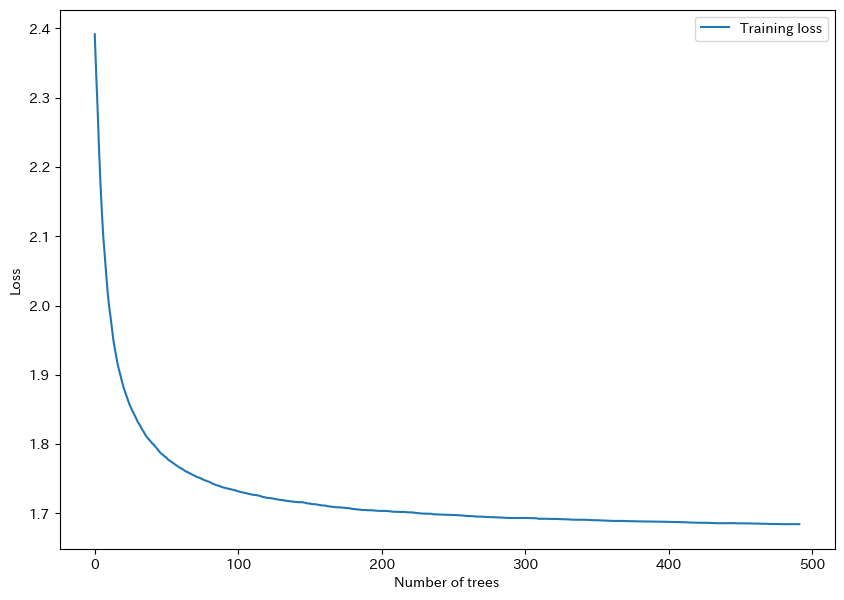

In [60]:
from matplotlib import pyplot as plt
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## Cleaning up the test dataset (same procedure as for train):

In [61]:
import gc
del train_x
del valid_x
del train_y
del valid_y
gc.collect()

45

In [62]:
test = pd.read_csv("/kaggle/input/narou/test.csv")
test.isna().sum()

novel_id                       0
title                          0
writer                         5
biggenre                       0
genre                          0
keyword                      389
isr15                          0
isbl                           0
isgl                           0
iszankoku                      0
istensei                       0
istenni                        0
kaiwaritu                      0
length_per_story               0
sasie_cnt_per_story            0
time_per_story_submission      0
dtype: int64

In [63]:
test.fillna({"keyword":"UNTAGGED_NOVEL"}, inplace=True)
test["keywords_set"] = test["keyword"].apply(lambda x: str_tags_to_set(x))


test["keyword_vector"] = test["keywords_set"].apply(vectorize_keywords_set)

test["isr15"] = test["isr15"].apply(string_binary_to_boolean)
test["isbl"] = test["isbl"].apply(string_binary_to_boolean)
test["isgl"] = test["isgl"].apply(string_binary_to_boolean)
test["iszankoku"] = test["iszankoku"].apply(string_binary_to_boolean)
test["istensei"] = test["istensei"].apply(string_binary_to_boolean)
test["istenni"] = test["istenni"].apply(string_binary_to_boolean)

test.fillna({"writer":"NO_AUTHOR"}, inplace=True)
test['writer_novels_written']=test['writer'].map(train['writer'].value_counts())
test.fillna({"writer_novels_written":1}, inplace=True)
test.loc[test['writer'] == "NO_AUTHOR", "writer_novels_written"] = 1 # Since "no author" isn't an actual author
test["title_length"] = test["title"].apply(len)

test["title_kanji"] = test["title"].apply(count_kanji)
test["title_hiragana"] = test["title"].apply(count_hiragana)
test["title_katakana"] = test["title"].apply(count_katakana)

test[["kaiwaritu","length_per_story","time_per_story_submission","writer_novels_written","sasie_cnt_per_story","title_length","title_kanji","title_hiragana","title_katakana"]] = scaler.transform(test[["kaiwaritu","length_per_story","time_per_story_submission", "writer_novels_written","sasie_cnt_per_story","title_length","title_kanji","title_hiragana","title_katakana"]].to_numpy())

test_genres_transformed = genre_encoder.transform(test[["genre"]])
test["genre"] = test_genres_transformed.toarray().tolist()
test["vectorized_title"] = test["title"].apply(lambda x : title_vectorizer.transform([x]).toarray()[0])




test_x = get_input_from_dataframe(test)

In [64]:
test["writer_novels_written"].describe()

count    40678.000000
mean         0.369476
std          0.370420
min          0.000000
25%          0.000000
50%          0.446947
75%          0.703704
max          0.997623
Name: writer_novels_written, dtype: float64

In [65]:
test_x

array([[0.        , 0.        , 0.        , ..., 0.6926927 , 0.23923925,
        0.8328328 ],
       [0.        , 0.        , 0.        , ..., 0.13603005, 0.5625626 ,
        0.8830643 ],
       [0.        , 0.        , 0.        , ..., 0.9214214 , 0.36136135,
        0.        ],
       ...,
       [1.        , 1.        , 0.        , ..., 0.87091124, 0.2012012 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.7317317 , 0.2112112 ,
        0.6862298 ],
       [1.        , 1.        , 0.        , ..., 0.5645646 , 0.57821923,
        0.6866867 ]], dtype=float32)

In [66]:
test_x.shape

(40678, 2334)

## Test dataset inference

In [67]:
test_y_log = model.predict(test_x)

In [68]:
test_y_log

array([4.9868884, 4.8687286, 5.7402234, ..., 2.0287817, 2.2677531,
       5.8934183], dtype=float32)

In [69]:
y_pred = np.expm1(test_y_log)

In [70]:
y_pred

array([145.47992  , 129.15533  , 310.1339   , ...,   6.6048155,
         8.657677 , 361.6428   ], dtype=float32)

## Csv file preparation

In [71]:
test["global_point"] = y_pred
test[["novel_id","global_point"]].to_csv("predictions.csv", index=False)

In [72]:
test["global_point"].describe()

count     40678.000000
mean        535.665466
std        3337.489258
min          -0.079887
25%          16.967507
50%          42.050411
75%         174.571644
max      184181.781250
Name: global_point, dtype: float64

In [73]:
test['global_point'] = test['global_point'].where(test['global_point'] >= 0, 0) # Clipping results to >0

In [74]:
test["global_point"].describe()

count     40678.000000
mean        535.665466
std        3337.489258
min           0.000000
25%          16.967507
50%          42.050411
75%         174.571644
max      184181.781250
Name: global_point, dtype: float64

In [75]:
test[["novel_id","global_point"]].to_csv("predictions.csv", index=False)

In [76]:
model.predict(test_x,iteration_range=(0, 120))

array([5.294416 , 4.794411 , 5.678208 , ..., 2.730723 , 2.4157228,
       5.9423943], dtype=float32)